## Aim 

- This notebook aims to balance the dataset using imlearn library

There is an error, either in the training data or validation dataset. 

Number of individuals that purchased in training dataset is only 9

Number of individuals that purchased in validation dataset is only very large


In [1]:
import pandas as pd 
import imblearn
import numpy as np
import optuna
from sklearn.metrics import recall_score, f1_score, precision_score
from tqdm import tqdm

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

Since it is recommended by author of SMOTE that both oversampling and undersampling are undertaken in the sampe 
experiment, that's the methodology we are following here

In [3]:
# Oversample with SMOTE and random undersample for imbalanced dataset
from collections import Counter # instead of value counts
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from matplotlib import pyplot
from numpy import where
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve


In [4]:
path = '../../curated_data/'

In [5]:
data = pd.read_csv(path + 'trial.csv', index_col = 0)

In [6]:
X = data.drop(['label', 'STATE_CODE', 'ZIP_CODE', 'last_tire_purchase'], axis = 1)
y = data.label

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify = y)

In [8]:
X_test_copy = X_test  # to retain indiv column 

In [9]:
X_test_copy.columns

Index(['indiv', 'cust_in_top_10_sales', 'store_top_tran',
       'store_top_tires_tran', 'vehicle_tire_svc', 'number_trans',
       'number_visits', 'number_visits_tire_purchase', 'vhc_tire_purchase',
       'vhc_early_tire_purchase', 'diff_from_last_tire_purch',
       'units_tires_purch', 'sales_tires_purch', 'number_trans_general',
       'indiv_make_tire_pch', 'make_prop', 'make_prop_tire', 'MODEL_prop',
       'MODEL_prop_tire', 'SUB_MODEL_prop', 'SUB_MODEL_prop_tire',
       'SEGMENT_DESC_Commercial Tires', 'SEGMENT_DESC_Commercial/Recreational',
       'SEGMENT_DESC_Industrial Tires', 'SEGMENT_DESC_Medium Truck Tires',
       'SEGMENT_DESC_Miscellaneous Tire Related Items',
       'SEGMENT_DESC_Other Passenger Tires',
       'SEGMENT_DESC_P Metric Light Truck Tires',
       'SEGMENT_DESC_P-Metric CUV/SUV', 'SEGMENT_DESC_Performance Tires',
       'SEGMENT_DESC_Recreational Tires', 'SEGMENT_DESC_Road Hazard',
       'SEGMENT_DESC_Snow Tires-LT', 'SEGMENT_DESC_Snow Tires-PS',
    

In [10]:
X_train = X_train.drop(['indiv'], axis = 1)
X_test = X_test.drop(['indiv'], axis = 1)

In [11]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3267737, 80), (3267737,), (1609483, 80), (1609483,))

In [12]:
X_train.head()

,cust_in_top_10_sales,store_top_tran,store_top_tires_tran,vehicle_tire_svc,number_trans,number_visits,number_visits_tire_purchase,vhc_tire_purchase,vhc_early_tire_purchase,diff_from_last_tire_purch,units_tires_purch,sales_tires_purch,number_trans_general,indiv_make_tire_pch,make_prop,make_prop_tire,MODEL_prop,MODEL_prop_tire,SUB_MODEL_prop,SUB_MODEL_prop_tire,SEGMENT_DESC_Commercial Tires,SEGMENT_DESC_Commercial/Recreational,SEGMENT_DESC_Industrial Tires,SEGMENT_DESC_Medium Truck Tires,SEGMENT_DESC_Miscellaneous Tire Related Items,SEGMENT_DESC_Other Passenger Tires,SEGMENT_DESC_P Metric Light Truck Tires,SEGMENT_DESC_P-Metric CUV/SUV,SEGMENT_DESC_Performance Tires,SEGMENT_DESC_Recreational Tires,SEGMENT_DESC_Road Hazard,SEGMENT_DESC_Snow Tires-LT,SEGMENT_DESC_Snow Tires-PS,SEGMENT_DESC_Touring,SEGMENT_DESC_Tubes,top_5_segment,CLASS_DESC_All-Terrain,CLASS_DESC_CUV/SUV All-Terrain,CLASS_DESC_CUV/SUV Highway All-Season,CLASS_DESC_CUV/SUV Sport Performance Summer,CLASS_DESC_Car & Minivan All-Season,CLASS_DESC_Economy Tires,CLASS_DESC_Garden Tires,CLASS_DESC_Highway All-Season,CLASS_DESC_Highway Tires,CLASS_DESC_Implement Tires/Industrial,CLASS_DESC_Industrial Tires,CLASS_DESC_Mass Market Tires,CLASS_DESC_Max Traction Tires,CLASS_DESC_Maximum Traction,CLASS_DESC_Misc/Discounts/Non-Inventoreable,CLASS_DESC_Other,CLASS_DESC_Other Passenger Tires,CLASS_DESC_Performance All-Season,CLASS_DESC_Radial Tires,CLASS_DESC_Rear Ag Tires,CLASS_DESC_Road Hazard,CLASS_DESC_S/T Performance Tires,CLASS_DESC_Snow Tires,CLASS_DESC_Snow Tires - All Terrain LT,CLASS_DESC_Snow Tires - Commercial LT,CLASS_DESC_Touring H/V/Z Tires,CLASS_DESC_Tubes,CLASS_DESC_Ultra High Performance All Season,CLASS_DESC_Ultra High Performance Summer,CLASS_DESC_Farm/Truck Services,CLASS_DESC_Misc. Tire Service,CLASS_DESC_Tire Mounting,CLASS_DESC_Tire Pressure Monitoring Systems,CLASS_DESC_Tire Rotation,CLASS_DESC_Valves,CROSS_SECTION,ASPECT_RATIO,RIM_SIZE,accept_perc,avg_temp,avg_max_temp,avg_prcp,avg_snow_depth,est_vmiles
3982706,0,1,1,0,0.0,0.0,0.0,0,0,NaN,NaN,NaN,1,1,0.051176,0,0.002445,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.698996,51.091841,111.221240,3.166925,688.882728,33.659608
4871715,0,1,1,0,0.0,0.0,0.0,0,0,NaN,NaN,NaN,1,1,0.118321,0,0.008724,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.953072,60.099716,223.088246,1.950531,887.031201,35.673774
4429308,0,1,1,1,29.0,5.0,0.0,0,0,NaN,NaN,NaN,5,1,0.118321,0,0.008724,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,0.803321,66.174949,200.803571,4.914208,802.827283,NaN
4452775,0,1,1,0,0.0,0.0,0.0,0,0,NaN,NaN,NaN,1,0,0.010814,0,0.001958,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.550144,61.917686,127.881437,2.146351,663.677065,NaN
4662430,0,1,1,1,3.0,1.0,0.0,0,0,NaN,NaN,NaN,1,1,0.118321,0,0.000192,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,0.699640,52.624780,86.790385,5.401213,782.592821,40.482388


## Preprocessing

In [13]:
bool_vars = [col for col in X_train
             if np.isin(X_train[col].dropna().unique(), [0, 1]).all()]

In [14]:
num_vars = X_train.drop(bool_vars, axis = 1).columns

In [15]:
bool_vars = X_train[bool_vars]

In [16]:
X_num = X_train[num_vars]

num_colnames = X_num.columns

bool_colnames = bool_vars.columns

In [17]:
imputer = SimpleImputer(strategy="median")

X_num = imputer.fit_transform(X_num)

bool_vars = imputer.fit_transform(bool_vars)

In [18]:
X_num_scaled = StandardScaler().fit_transform(X_num)

In [19]:
X_num = pd.DataFrame(X_num, columns = num_colnames)
bool_vars = pd.DataFrame(bool_vars, columns = bool_colnames)

In [20]:
bool_vars.fillna(0, inplace = True)

In [21]:
X_train = pd.concat([X_num, bool_vars], axis = 1)

## Preprocessing for valid set

In [22]:
bool_vars = [col for col in X_test
             if np.isin(X_test[col].dropna().unique(), [0, 1]).all()]

In [23]:
num_vars = X_test.drop(bool_vars, axis = 1).columns

In [24]:
bool_vars = X_test[bool_vars]

In [24]:
X_num = X_test[num_vars]

num_colnames = X_num.columns

bool_colnames = bool_vars.columns

In [25]:
imputer = SimpleImputer(strategy="median")

X_num = imputer.fit_transform(X_num)

bool_vars = imputer.fit_transform(bool_vars)

In [26]:
X_num_scaled = StandardScaler().fit_transform(X_num)

In [27]:
X_num = pd.DataFrame(X_num, columns = num_colnames)
bool_vars = pd.DataFrame(bool_vars, columns = bool_colnames)

In [28]:
bool_vars.fillna(0, inplace = True)

In [29]:
X_test = pd.concat([X_num, bool_vars], axis = 1)

In [30]:
X_test.shape

(1609483, 80)

### summarize class distribution

In [31]:
counter = Counter(y_train)
print(counter)

Counter({0: 3193085, 1: 74652})


### define pipeline

In [25]:
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X_train, y_train = pipeline.fit_resample(X_train, y_train)

### summarize the new class distribution

In [33]:
counter = Counter(y_train)
print(counter)

Counter({0: 638616, 1: 319308})


## Fine tuning with optuna

### Optimizing for f1

In [34]:
def objective(trial):
    dtrain = lgb.Dataset(X_train, label=y_train)

    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "learning_rate": trial.suggest_float("learning_rate", 1e-8, 1, log=True),
        'n_estimators': trial.suggest_int("n_estimators", 200, 1000),
        'max_depth' : trial.suggest_int("max_depth", -20, 20),
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(X_test)
    pred_labels = np.rint(preds)
    f1 = f1_score(y_test, pred_labels)
    return f1

In [35]:
def run(n = 10): 
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("{}: {}".format(key, value))

In [36]:
run(20)

[I 2022-05-04 05:14:57,949] A new study created in memory with name: no-name-28ce0a66-3c14-4d58-a55e-807e8bcad3b4
/data/p_dsi/envs/neuro501/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-05-04 05:15:21,706] Trial 0 finished with value: 0.06601442433252305 and parameters: {'learning_rate': 0.16731816256727866, 'n_estimators': 403, 'max_depth': 14, 'lambda_l1': 0.0026760967651932926, 'lambda_l2': 2.1713175112461235e-07, 'num_leaves': 124, 'feature_fraction': 0.448478313607043, 'bagging_fraction': 0.7344076223594624, 'bagging_freq': 7, 'min_child_samples': 42}. Best is trial 0 with value: 0.06601442433252305.
/data/p_dsi/envs/neuro501/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead

/data/p_dsi/envs/neuro501/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-05-04 05:24:59,829] Trial 12 finished with value: 0.0 and parameters: {'learning_rate': 0.0002489066819785747, 'n_estimators': 720, 'max_depth': 5, 'lambda_l1': 1.0937293194623814e-08, 'lambda_l2': 1.189053332946535e-06, 'num_leaves': 175, 'feature_fraction': 0.8137178164960591, 'bagging_fraction': 0.9960246575924814, 'bagging_freq': 3, 'min_child_samples': 32}. Best is trial 11 with value: 0.08525484362271102.
/data/p_dsi/envs/neuro501/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2022-05-04 05:25:43,481] Trial 13 finished with value: 0.08056034808669173 and parameters: {'learning_rate':

Number of finished trials: 20
Best trial:
  Value: 0.08525484362271102
  Params: 
learning_rate: 0.0021681816274656284
n_estimators: 780
max_depth: 6
lambda_l1: 3.294915199526411e-08
lambda_l2: 1.525088533910007e-06
num_leaves: 126
feature_fraction: 0.97664077074572
bagging_fraction: 0.9299070526120212
bagging_freq: 3
min_child_samples: 46


## Lightgbm

In [26]:
model = lgb.LGBMClassifier( learning_rate  =  0.0021681816274656284,
n_estimators =  780,
max_depth =  6,
lambda_l1 =  3.294915199526411e-08,
lambda_l2 =  1.525088533910007e-06,
num_leaves =  126,
feature_fraction =  0.97664077074572,
bagging_fraction =  0.9299070526120212,
bagging_freq =  3,
min_child_samples =  46,random_state = 42)

model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
          verbose=10,eval_metric='logloss')

/data/p_dsi/envs/neuro501/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l1 is set=3.294915199526411e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.294915199526411e-08
[LightGBM] [Warning] bagging_fraction is set=0.9299070526120212, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9299070526120212
[LightGBM] [Warning] feature_fraction is set=0.97664077074572, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.97664077074572
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.525088533910007e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.525088533910007e-06
[10]	training's binary_logloss: 0.62888	valid_0's binary_logloss: 0.41826
[20]	training's binary_logloss: 0.621662	valid_0's binary_logloss: 0.4153
[30]	training's binary_logloss: 0.614687	valid_0's binary_logloss: 0.411701
[40]	training's binary_logloss: 0.608104	valid_0's binary_logloss: 0.408516
[50]	training's 

LGBMClassifier(bagging_fraction=0.9299070526120212, bagging_freq=3,
               feature_fraction=0.97664077074572,
               lambda_l1=3.294915199526411e-08, lambda_l2=1.525088533910007e-06,
               learning_rate=0.0021681816274656284, max_depth=6,
               min_child_samples=46, n_estimators=780, num_leaves=126,
               random_state=42)

In [38]:
# lgb.save(model, path + 'model.txt')
# model.booster_.save_model(path +'model.txt')

In [39]:
X_train.columns

Index(['number_trans', 'number_visits', 'number_visits_tire_purchase',
       'diff_from_last_tire_purch', 'units_tires_purch', 'sales_tires_purch',
       'number_trans_general', 'make_prop', 'MODEL_prop', 'SUB_MODEL_prop',
       'CROSS_SECTION', 'ASPECT_RATIO', 'RIM_SIZE', 'accept_perc', 'avg_temp',
       'avg_max_temp', 'avg_prcp', 'avg_snow_depth', 'est_vmiles',
       'cust_in_top_10_sales', 'store_top_tran', 'store_top_tires_tran',
       'vehicle_tire_svc', 'vhc_tire_purchase', 'vhc_early_tire_purchase',
       'indiv_make_tire_pch', 'make_prop_tire', 'MODEL_prop_tire',
       'SUB_MODEL_prop_tire', 'SEGMENT_DESC_Commercial Tires',
       'SEGMENT_DESC_Commercial/Recreational', 'SEGMENT_DESC_Industrial Tires',
       'SEGMENT_DESC_Medium Truck Tires',
       'SEGMENT_DESC_Miscellaneous Tire Related Items',
       'SEGMENT_DESC_Other Passenger Tires',
       'SEGMENT_DESC_P Metric Light Truck Tires',
       'SEGMENT_DESC_P-Metric CUV/SUV', 'SEGMENT_DESC_Performance Tires',
    

### Model importance

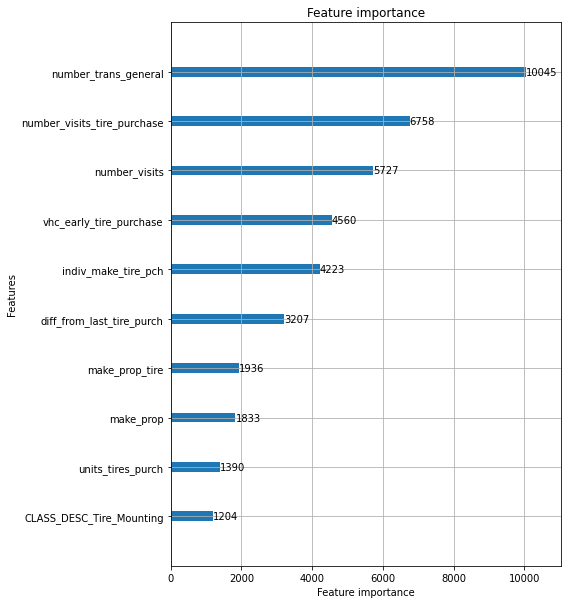

In [43]:
lgb.plot_importance(model, max_num_features = 10, figsize = (7, 10));

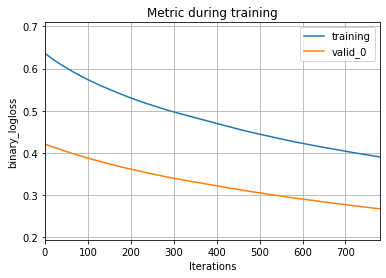

In [44]:
lgb.plot_metric(model);

/data/p_dsi/envs/neuro501/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


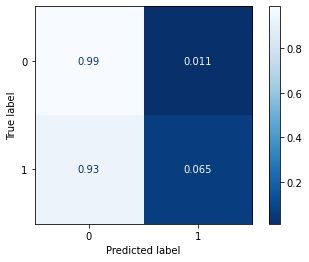

In [47]:
plot_confusion_matrix(model,X_test,y_test,cmap='Blues_r', normalize = 'true');

In [46]:
print(classification_report(y_test,model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98   1572714
           1       0.12      0.07      0.08     36769

    accuracy                           0.97   1609483
   macro avg       0.55      0.53      0.53   1609483
weighted avg       0.96      0.97      0.96   1609483



## Drawing the precision recall curve to optimize threshold

In [35]:
yhat = model.predict_proba(X_test)

In [36]:
yhat = yhat[:, 1]

In [50]:
precision, recall, thresholds = precision_recall_curve(y_test, yhat)

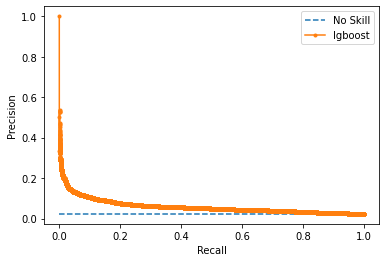

In [51]:
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='lgboost')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()

In [52]:
from numpy import argmax, arange


In [53]:
thresholds = arange(0, 1, 0.015)

In [54]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

In [64]:
# scores = [recall(y_test, to_labels(yhat, t)) for t in thresholds]

f1_scores = []

for i in tqdm(thresholds):
    f1_scores.append(f1_score(y_test, to_labels(yhat, i)))

100%|██████████| 67/67 [00:39<00:00,  1.72it/s]


In [67]:
from numpy import argmax

In [69]:
ix = argmax(f1_scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], f1_scores[ix]))

Threshold=0.360, F-Score=0.11239


In [87]:
print('Recall=%.5f' % recall_score(y_test, to_labels(yhat, 0.36)))

Recall=0.16609


In [90]:
print('Precision=%.5f' % precision_score(y_test,to_labels(yhat, 0.36)))

Precision=0.08493


# Preliminary list of individuals

In [73]:
y_test_copy = y_test

In [74]:
y_test_copy = y_test_copy.to_frame()

In [72]:
# y_test_copy['prediction'] = model.predict(X_test)

In [75]:
# y_test_copy['predicted_proba'] = model.predict_proba(X_test).max(axis = 1)
# predic_prob = pd.DataFrame(model.predict_proba(X_test), columns=model.classes_).iloc[:, 1]

# y_test_copy = pd.concat([y_test_copy, predic_prob], axis = 1)

y_test_copy['predicted_proba'] = yhat

In [76]:
y_test_copy.shape

(1609483, 2)

In [77]:
y_test_copy.head(20)

,label,predicted_proba
494033,1,0.217875
4246612,0,0.158478
2229043,0,0.166838
3497153,0,0.162781
3179669,0,0.142175
1675708,0,0.273170
2974945,0,0.134619
231188,0,0.172852
4437483,0,0.157916
280180,0,0.166767


In [78]:
y_test_copy['ID'] = X_test_copy['indiv'].astype('int')

In [79]:
y_test_copy.head()

,label,predicted_proba,ID
494033,1,0.217875,283405863
4246612,0,0.158478,268965733
2229043,0,0.166838,259486935
3497153,0,0.162781,280162235
3179669,0,0.142175,321521773


In [113]:
# indiv_ID = y_test_copy.query('prediction == 1')

In [80]:
## positive label 

pos_label = set(y_test_copy.query('label == 1').ID)

In [81]:
## positive prediction

# pos_pred = set(y_test_copy.query('prediction == 1').ID)

pos_pred = y_test_copy.nlargest(100000, columns = 'predicted_proba').ID

In [82]:
len(set(pos_pred).intersection(set(pos_label)))/ len(set(pos_pred))

0.0742

In [83]:
ids = pos_pred.reset_index()[['ID']]

In [135]:
# ids.to_csv(path + 'IDs.csv')

,ID
0,265007738
1,257186387
2,294401795
3,271427891
4,308722902


In [27]:
#load from model:

# model = lgb.Booster(model_file= path + 'model.txt')

col_to_use = ['indiv', 'number_trans', 'number_visits', 'number_visits_tire_purchase',
       'diff_from_last_tire_purch', 'units_tires_purch', 'sales_tires_purch',
       'number_trans_general', 'make_prop', 'MODEL_prop', 'SUB_MODEL_prop',
       'CROSS_SECTION', 'ASPECT_RATIO', 'RIM_SIZE', 'accept_perc', 'avg_temp',
       'avg_max_temp', 'avg_prcp', 'avg_snow_depth', 'est_vmiles',
       'cust_in_top_10_sales', 'store_top_tran', 'store_top_tires_tran',
       'vehicle_tire_svc', 'vhc_tire_purchase', 'vhc_early_tire_purchase',
       'indiv_make_tire_pch', 'make_prop_tire', 'MODEL_prop_tire',
       'SUB_MODEL_prop_tire', 'SEGMENT_DESC_Commercial Tires',
       'SEGMENT_DESC_Commercial/Recreational', 'SEGMENT_DESC_Industrial Tires',
       'SEGMENT_DESC_Medium Truck Tires',
       'SEGMENT_DESC_Miscellaneous Tire Related Items',
       'SEGMENT_DESC_Other Passenger Tires',
       'SEGMENT_DESC_P Metric Light Truck Tires',
       'SEGMENT_DESC_P-Metric CUV/SUV', 'SEGMENT_DESC_Performance Tires',
       'SEGMENT_DESC_Recreational Tires', 'SEGMENT_DESC_Road Hazard',
       'SEGMENT_DESC_Snow Tires-LT', 'SEGMENT_DESC_Snow Tires-PS',
       'SEGMENT_DESC_Touring', 'SEGMENT_DESC_Tubes', 'top_5_segment',
       'CLASS_DESC_All-Terrain', 'CLASS_DESC_CUV/SUV All-Terrain',
       'CLASS_DESC_CUV/SUV Highway All-Season',
       'CLASS_DESC_CUV/SUV Sport Performance Summer',
       'CLASS_DESC_Car & Minivan All-Season', 'CLASS_DESC_Economy Tires',
       'CLASS_DESC_Garden Tires', 'CLASS_DESC_Highway All-Season',
       'CLASS_DESC_Highway Tires', 'CLASS_DESC_Implement Tires/Industrial',
       'CLASS_DESC_Industrial Tires', 'CLASS_DESC_Mass Market Tires',
       'CLASS_DESC_Max Traction Tires', 'CLASS_DESC_Maximum Traction',
       'CLASS_DESC_Misc/Discounts/Non-Inventoreable', 'CLASS_DESC_Other',
       'CLASS_DESC_Other Passenger Tires', 'CLASS_DESC_Performance All-Season',
       'CLASS_DESC_Radial Tires', 'CLASS_DESC_Rear Ag Tires',
       'CLASS_DESC_Road Hazard', 'CLASS_DESC_S/T Performance Tires',
       'CLASS_DESC_Snow Tires', 'CLASS_DESC_Snow Tires - All Terrain LT',
       'CLASS_DESC_Snow Tires - Commercial LT',
       'CLASS_DESC_Touring H/V/Z Tires', 'CLASS_DESC_Tubes',
       'CLASS_DESC_Ultra High Performance All Season',
       'CLASS_DESC_Ultra High Performance Summer',
       'CLASS_DESC_Farm/Truck Services', 'CLASS_DESC_Misc. Tire Service',
       'CLASS_DESC_Tire Mounting',
       'CLASS_DESC_Tire Pressure Monitoring Systems',
       'CLASS_DESC_Tire Rotation', 'CLASS_DESC_Valves']

In [28]:
data15_17 = pd.read_csv(path + 'trial.csv', index_col = 0, usecols = lambda x: x in col_to_use)

data18 = pd.read_csv(path + 'year18.csv', index_col = 0, usecols = lambda x: x in col_to_use)

In [29]:
a = data15_17.columns
b = data18.columns

In [30]:
print(len(a))
len(b)

80


79

In [31]:
data15_17.head()

,cust_in_top_10_sales,store_top_tran,store_top_tires_tran,vehicle_tire_svc,number_trans,number_visits,number_visits_tire_purchase,vhc_tire_purchase,vhc_early_tire_purchase,diff_from_last_tire_purch,units_tires_purch,sales_tires_purch,number_trans_general,indiv_make_tire_pch,make_prop,make_prop_tire,MODEL_prop,MODEL_prop_tire,SUB_MODEL_prop,SUB_MODEL_prop_tire,SEGMENT_DESC_Commercial Tires,SEGMENT_DESC_Commercial/Recreational,SEGMENT_DESC_Industrial Tires,SEGMENT_DESC_Medium Truck Tires,SEGMENT_DESC_Miscellaneous Tire Related Items,SEGMENT_DESC_Other Passenger Tires,SEGMENT_DESC_P Metric Light Truck Tires,SEGMENT_DESC_P-Metric CUV/SUV,SEGMENT_DESC_Performance Tires,SEGMENT_DESC_Recreational Tires,SEGMENT_DESC_Road Hazard,SEGMENT_DESC_Snow Tires-LT,SEGMENT_DESC_Snow Tires-PS,SEGMENT_DESC_Touring,SEGMENT_DESC_Tubes,top_5_segment,CLASS_DESC_All-Terrain,CLASS_DESC_CUV/SUV All-Terrain,CLASS_DESC_CUV/SUV Highway All-Season,CLASS_DESC_CUV/SUV Sport Performance Summer,CLASS_DESC_Car & Minivan All-Season,CLASS_DESC_Economy Tires,CLASS_DESC_Garden Tires,CLASS_DESC_Highway All-Season,CLASS_DESC_Highway Tires,CLASS_DESC_Implement Tires/Industrial,CLASS_DESC_Industrial Tires,CLASS_DESC_Mass Market Tires,CLASS_DESC_Max Traction Tires,CLASS_DESC_Maximum Traction,CLASS_DESC_Misc/Discounts/Non-Inventoreable,CLASS_DESC_Other,CLASS_DESC_Other Passenger Tires,CLASS_DESC_Performance All-Season,CLASS_DESC_Radial Tires,CLASS_DESC_Rear Ag Tires,CLASS_DESC_Road Hazard,CLASS_DESC_S/T Performance Tires,CLASS_DESC_Snow Tires,CLASS_DESC_Snow Tires - All Terrain LT,CLASS_DESC_Snow Tires - Commercial LT,CLASS_DESC_Touring H/V/Z Tires,CLASS_DESC_Tubes,CLASS_DESC_Ultra High Performance All Season,CLASS_DESC_Ultra High Performance Summer,CLASS_DESC_Farm/Truck Services,CLASS_DESC_Misc. Tire Service,CLASS_DESC_Tire Mounting,CLASS_DESC_Tire Pressure Monitoring Systems,CLASS_DESC_Tire Rotation,CLASS_DESC_Valves,CROSS_SECTION,ASPECT_RATIO,RIM_SIZE,accept_perc,avg_temp,avg_max_temp,avg_prcp,avg_snow_depth,est_vmiles
indiv,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
295141827.0,0,1,1,1,13.0,2.0,0.0,0,0,NaN,NaN,NaN,2,1,0.132760,0,0.010292,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,0.806615,53.583762,209.554022,10.510378,749.864162,28.370008
303947384.0,0,1,1,0,0.0,0.0,0.0,0,0,NaN,NaN,NaN,1,1,0.132760,0,0.004369,0,0.039052,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.899143,68.478161,212.002604,5.393065,937.507745,39.857000
486895284.0,0,1,1,1,103.0,15.0,2.0,1,1,0.0,6.0,475.22,17,1,0.051176,0,0.000058,0,0.000085,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,205.0,60.0,16.0,0.806615,53.583762,209.554022,10.510378,749.864162,28.370008
303949519.0,0,1,1,1,10.0,1.0,1.0,1,1,30.0,4.0,343.96,1,1,0.051176,0,0.000300,0,0.002137,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,225.0,65.0,17.0,0.906056,50.266034,195.417222,21.229688,661.832481,37.529362
301787904.0,0,1,1,1,9.0,1.0,0.0,0,0,NaN,NaN,NaN,1,1,0.051176,0,0.001637,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,0.699640,52.624780,86.790385,5.401213,782.592821,39.066098


In [32]:
list(set(a) ^ set(b))  # then no worries - this will be filled with NAs in the other dataset

['CLASS_DESC_Implement Tires/Industrial']

In [33]:
data = pd.concat([data15_17, data18])

In [34]:
data.shape

(7500834, 80)

In [35]:
X_test = data

In [36]:
X_test_copy = X_test  # to retain indiv column 

In [37]:
X_test.columns

Index(['cust_in_top_10_sales', 'store_top_tran', 'store_top_tires_tran',
       'vehicle_tire_svc', 'number_trans', 'number_visits',
       'number_visits_tire_purchase', 'vhc_tire_purchase',
       'vhc_early_tire_purchase', 'diff_from_last_tire_purch',
       'units_tires_purch', 'sales_tires_purch', 'number_trans_general',
       'indiv_make_tire_pch', 'make_prop', 'make_prop_tire', 'MODEL_prop',
       'MODEL_prop_tire', 'SUB_MODEL_prop', 'SUB_MODEL_prop_tire',
       'SEGMENT_DESC_Commercial Tires', 'SEGMENT_DESC_Commercial/Recreational',
       'SEGMENT_DESC_Industrial Tires', 'SEGMENT_DESC_Medium Truck Tires',
       'SEGMENT_DESC_Miscellaneous Tire Related Items',
       'SEGMENT_DESC_Other Passenger Tires',
       'SEGMENT_DESC_P Metric Light Truck Tires',
       'SEGMENT_DESC_P-Metric CUV/SUV', 'SEGMENT_DESC_Performance Tires',
       'SEGMENT_DESC_Recreational Tires', 'SEGMENT_DESC_Road Hazard',
       'SEGMENT_DESC_Snow Tires-LT', 'SEGMENT_DESC_Snow Tires-PS',
       'SEGME

In [38]:
X_test = X_test.reset_index(drop = True)

In [39]:
X_test.shape

(7500834, 80)

In [40]:
X_test.head()

,cust_in_top_10_sales,store_top_tran,store_top_tires_tran,vehicle_tire_svc,number_trans,number_visits,number_visits_tire_purchase,vhc_tire_purchase,vhc_early_tire_purchase,diff_from_last_tire_purch,units_tires_purch,sales_tires_purch,number_trans_general,indiv_make_tire_pch,make_prop,make_prop_tire,MODEL_prop,MODEL_prop_tire,SUB_MODEL_prop,SUB_MODEL_prop_tire,SEGMENT_DESC_Commercial Tires,SEGMENT_DESC_Commercial/Recreational,SEGMENT_DESC_Industrial Tires,SEGMENT_DESC_Medium Truck Tires,SEGMENT_DESC_Miscellaneous Tire Related Items,SEGMENT_DESC_Other Passenger Tires,SEGMENT_DESC_P Metric Light Truck Tires,SEGMENT_DESC_P-Metric CUV/SUV,SEGMENT_DESC_Performance Tires,SEGMENT_DESC_Recreational Tires,SEGMENT_DESC_Road Hazard,SEGMENT_DESC_Snow Tires-LT,SEGMENT_DESC_Snow Tires-PS,SEGMENT_DESC_Touring,SEGMENT_DESC_Tubes,top_5_segment,CLASS_DESC_All-Terrain,CLASS_DESC_CUV/SUV All-Terrain,CLASS_DESC_CUV/SUV Highway All-Season,CLASS_DESC_CUV/SUV Sport Performance Summer,CLASS_DESC_Car & Minivan All-Season,CLASS_DESC_Economy Tires,CLASS_DESC_Garden Tires,CLASS_DESC_Highway All-Season,CLASS_DESC_Highway Tires,CLASS_DESC_Implement Tires/Industrial,CLASS_DESC_Industrial Tires,CLASS_DESC_Mass Market Tires,CLASS_DESC_Max Traction Tires,CLASS_DESC_Maximum Traction,CLASS_DESC_Misc/Discounts/Non-Inventoreable,CLASS_DESC_Other,CLASS_DESC_Other Passenger Tires,CLASS_DESC_Performance All-Season,CLASS_DESC_Radial Tires,CLASS_DESC_Rear Ag Tires,CLASS_DESC_Road Hazard,CLASS_DESC_S/T Performance Tires,CLASS_DESC_Snow Tires,CLASS_DESC_Snow Tires - All Terrain LT,CLASS_DESC_Snow Tires - Commercial LT,CLASS_DESC_Touring H/V/Z Tires,CLASS_DESC_Tubes,CLASS_DESC_Ultra High Performance All Season,CLASS_DESC_Ultra High Performance Summer,CLASS_DESC_Farm/Truck Services,CLASS_DESC_Misc. Tire Service,CLASS_DESC_Tire Mounting,CLASS_DESC_Tire Pressure Monitoring Systems,CLASS_DESC_Tire Rotation,CLASS_DESC_Valves,CROSS_SECTION,ASPECT_RATIO,RIM_SIZE,accept_perc,avg_temp,avg_max_temp,avg_prcp,avg_snow_depth,est_vmiles
0,0,1,1,1,13.0,2.0,0.0,0,0,NaN,NaN,NaN,2,1,0.132760,0,0.010292,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,0.806615,53.583762,209.554022,10.510378,749.864162,28.370008
1,0,1,1,0,0.0,0.0,0.0,0,0,NaN,NaN,NaN,1,1,0.132760,0,0.004369,0,0.039052,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.899143,68.478161,212.002604,5.393065,937.507745,39.857000
2,0,1,1,1,103.0,15.0,2.0,1,1,0.0,6.0,475.22,17,1,0.051176,0,0.000058,0,0.000085,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,205.0,60.0,16.0,0.806615,53.583762,209.554022,10.510378,749.864162,28.370008
3,0,1,1,1,10.0,1.0,1.0,1,1,30.0,4.0,343.96,1,1,0.051176,0,0.000300,0,0.002137,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,225.0,65.0,17.0,0.906056,50.266034,195.417222,21.229688,661.832481,37.529362
4,0,1,1,1,9.0,1.0,0.0,0,0,NaN,NaN,NaN,1,1,0.051176,0,0.001637,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,0.699640,52.624780,86.790385,5.401213,782.592821,39.066098


## Preprocessing for test set

In [41]:
bool_vars = [col for col in X_test
             if np.isin(X_test[col].dropna().unique(), [0, 1]).all()]

In [42]:
num_vars = X_test.drop(bool_vars, axis = 1).columns

In [43]:
bool_vars = X_test[bool_vars]

In [44]:
X_num = X_test[num_vars]

num_colnames = X_num.columns

bool_colnames = bool_vars.columns

In [45]:
imputer = SimpleImputer(strategy="median")

X_num = imputer.fit_transform(X_num)

bool_vars = imputer.fit_transform(bool_vars)

In [46]:
X_num_scaled = StandardScaler().fit_transform(X_num)

In [47]:
X_num = pd.DataFrame(X_num, columns = num_colnames)
bool_vars = pd.DataFrame(bool_vars, columns = bool_colnames)

In [48]:
bool_vars.fillna(0, inplace = True)

In [49]:
X_test = pd.concat([X_num, bool_vars], axis = 1)

In [50]:
X_test.shape

(7500834, 80)

# List of individuals

In [52]:
yhat = model.predict_proba(X_test)

In [53]:
yhat = yhat[:, 1]

In [59]:
id = X_test_copy.reset_index()[['indiv']]

In [60]:
id['yhat'] = yhat

In [61]:
id.head()

,indiv,yhat
0,295141827.0,0.191376
1,303947384.0,0.196885
2,486895284.0,0.342957
3,303949519.0,0.136344
4,301787904.0,0.219979


In [66]:
id_chosen = id.nlargest(100000, columns = 'yhat')[['indiv']]

In [67]:
id_chosen.columns = ['ID']

In [68]:
id_chosen.head()

,ID
26983,273858791.0
30674,272441563.0
45318,273882014.0
263100,263959958.0
272590,275635085.0


In [69]:
ids = id_chosen.reset_index()[['ID']]

In [73]:
ids['ID'] = ids.ID.astype('int')

In [76]:
ids.head()
ids.shape

(100000, 1)

In [75]:
ids.to_csv(path + 'IDs.csv')